In [1]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/bensonmanner/Desktop/ACME/WebbResearch/Projects/Optimization/delay-optimizer')
import pandas as pd
from DelayEffects.Analyzer import Analyzer

# Helper Functions

In [2]:
# Initialize
loss_name = 'Ackley'
ackley2d = Analyzer(2, loss_name)
ackley10d = Analyzer(10, loss_name)
ackley100d = Analyzer(100, loss_name)
ackley1000d = Analyzer(1000, loss_name)
ackley10000d = Analyzer(10000, loss_name)

In [3]:
# Helper Functions
def fill_table(analyzer, max_L, num_points, partials=[0.2, 0.5, 0.8], same_points=False):
    # Initialize data array
    data = np.nan*np.zeros((4, 3 + 2*len(partials)))
    
    # Initialize column and index names
    columns = ['No Change', 'On/Off', 'Decaying']
    new_cols = []
    for percent in partials:
        columns.append("Partial ({}%)".format(percent*100))
        new_cols.append("Stochastic Partial ({}%)".format(percent*100))
    columns += new_cols
    indices = ['Constant', 'Periodic', 'Stochastic', 'Undelayed']
    
    # Use the same initial points for all calculations?
    if same_points is True:
        analyzer.initialize_points(num_points, 'random')
        gen_points = False
    
    # Perform the computations
    # Constant
    data[0,0] = test(analyzer, "constant", "same", max_L, num_points, print_vals=False, gen_points=gen_points)
    data[0,1] = test(analyzer, "constant", "binary", max_L, num_points, print_vals=False, gen_points=gen_points)
    data[0,2] = test(analyzer, "constant", "decay", max_L, num_points, print_vals=False, gen_points=gen_points)
    for i, percent in enumerate(partials):
        data[0,3+i] = test(analyzer, "constant", "partial", max_L, num_points, percent=percent, print_vals=False, 
                           gen_points=gen_points)
        data[0,3+i+len(partials)] = test(analyzer, "constant", "partial", max_L, num_points, percent=percent, 
                                         stochastic_partials=True, print_vals=False, gen_points=gen_points)
        
    # Periodic
    data[1,0] = test(analyzer, "periodic", "same", max_L, num_points, print_vals=False)
    data[1,1] = test(analyzer, "periodic", "binary", max_L, num_points, print_vals=False)
    data[1,2] = test(analyzer, "periodic", "decay", max_L, num_points, print_vals=False)
    for i, percent in enumerate(partials):
        data[1,3+i] = test(analyzer, "periodic", "partial", max_L, num_points, percent=percent, print_vals=False, 
                           gen_points=gen_points)
        data[1,3+i+len(partials)] = test(analyzer, "periodic", "partial", max_L, num_points, percent=percent, 
                                         stochastic_partials=True, print_vals=False, gen_points=gen_points)
        
    # Stochastic
    data[2,0] = test(analyzer, "stochastic", "same", max_L, num_points, print_vals=False, gen_points=gen_points)
    data[2,1] = test(analyzer, "stochastic", "binary", max_L, num_points, print_vals=False, gen_points=gen_points)
    data[2,2] = test(analyzer, "stochastic", "decay", max_L, num_points, print_vals=False, gen_points=gen_points)
    for i, percent in enumerate(partials):
        data[2,3+i] = test(analyzer, "stochastic", "partial", max_L, num_points, percent=percent, print_vals=False, 
                           gen_points=gen_points)
        data[2,3+i+len(partials)] = test(analyzer, "stochastic", "partial", max_L, num_points, percent=percent, 
                                         stochastic_partials=True, print_vals=False, gen_points=gen_points)
        
    # Undelayed
    analyzer.calculate_save_values(False, save_grad=False, save_state=False, save_iters=False, break_opt=False)
    data[3,0] = np.mean(analyzer.final_losses)
        
    # Create the dataframe
    dataframe = pd.DataFrame(data, index=indices, columns=columns)
    dataframe.style.set_caption("Rosenbrock Function | n={} | Max Delay is {}".format(analyzer.n, analyzer.max_L))
    
    return dataframe
    
        
def test(analyzer, test_type, dist_type, max_L, num_points, stochastic_partials=False, percent=0.5, 
         print_vals=True, gen_points=True):
    # Initialize
    n = analyzer.n
    maxiter = analyzer.maxiter
    num_delays = 1000   # How many iterations to delay for binary distributions
    random = False
    
    if test_type == 'constant':
        if dist_type == 'same':
            # Delays are all equal to max_L in every dimension for the full number of iterations
            print_str = "No Change Constant"
            D = max_L * np.ones(n, dtype=int)
            D = [D]
            analyzer.initialize_vars(num_delays=maxiter, max_L=max_L)
        elif dist_type == 'binary':
            # Delays are all equal to max_L in every dimension, but delays are turned off after 1000 iterations
            print_str = "On/Off Constant"
            D = max_L * np.ones(n, dtype=int)
            D = [D]
            analyzer.initialize_vars(num_delays=num_delays, max_L=max_L)
        elif dist_type == 'decay':
            # Delays start with max_L in every dimension and decrease over time
            print_str = "Decaying Constant"
            D = []
            D_s = np.linspace(max_L+0.4999, -0.4999, maxiter) + 0.5
            D_s = D_s.astype(int)
            for i in range(maxiter):
                D.append(D_s[i]*np.ones(n, dtype=int))
            analyzer.initialize_vars(num_delays=maxiter, max_L=max_L)
        elif dist_type == 'partial':
            # Delays are all equal to max_L, but only in some of the dimensions (others are undelayed)
            if analyzer.n < 4 and percent != 0.5:
                return np.nan
            if stochastic_partials is True:
                # Choose which dimensions are delayable stochastically each iteration
                print_str = "{} Stochastic Partial Constant".format(percent)
                D = []
                for i in range(maxiter):
                    iter_delay = np.zeros(n, dtype=int)
                    for dim in range(n):
                        if np.random.random() < percent:
                            iter_delay[dim] = max_L
                    D.append(iter_delay)
            else:
                # Choose the first dimensions as the ones to be delayable
                print_str = "{} Partial Constant".format(percent)
                num_delay_dims = int(percent*n)
                D_s = np.zeros(n, dtype=int)
                D_s[0:num_delay_dims] = max_L
                D = [D_s]
            analyzer.initialize_vars(num_delays=maxiter, max_L=max_L)
        else:
            raise ValueError("{} is not a valid distribution type".format(dist_type))
            
    elif test_type == 'periodic':
        if dist_type == 'same':
            # Delays alternate over time between max_L and 0 (no delay) for the full number of iterations
            print_str = "No Change Periodic"
            D = [max_L*np.ones(n, dtype=int), np.zeros(n, dtype=int)]
            analyzer.initialize_vars(num_delays=maxiter, max_L=max_L)
        elif dist_type == 'binary':
            # Delays alternate over time between max_L and 0, and delays are turned off after 1000 iterations
            print_str = "On/Off Periodic"
            D = [max_L*np.ones(n, dtype=int), np.zeros(n, dtype=int)]
            analyzer.initialize_vars(num_delays=num_delays, max_L=max_L)
        elif dist_type == 'decay':
            # Delays alternate over time between max_L and 0, but max_L decreases over time
            print_str = "Decaying Periodic"
            D = []
            D_s = np.linspace(max_L+0.4999, -0.4999, maxiter) + 0.5
            D_s = D_s.astype(int)
            for i in range(maxiter):
                if i % 2 == 0:
                    D.append(D_s[i]*np.ones(n, dtype=int))
                else:
                    D.append(np.zeros(n, dtype=int))
            analyzer.initialize_vars(num_delays=maxiter, max_L=max_L)
        elif dist_type == 'partial':
            # Delays alternate over time between max_L and 0, but only in some of the dimensions (others are undelayed)
            if analyzer.n < 4 and percent != 0.5:
                return np.nan
            if stochastic_partials is True:
                print_str = "{} Stochastic Partial Periodic".format(percent)
                # Choose which dimensions are delayable stochastically each iteration
                D = []
                for i in range(maxiter):
                    iter_delay = np.zeros(n, dtype=int)
                    if i % 2 == 0:
                        for dim in range(n):
                            if np.random.random() < percent:
                                iter_delay[dim] = max_L
                    D.append(iter_delay)
            else:
                # Choose the first dimensions as the ones to be delayable
                print_str = "{} Partial Periodic".format(percent)
                num_delay_dims = int(percent*n)
                D_s = np.zeros(n, dtype=int)
                D_s[0:num_delay_dims] = max_L
                D = [D_s, np.zeros(n, dtype=int)]
            analyzer.initialize_vars(num_delays=maxiter, max_L=max_L)
        else:
            raise ValueError("{} is not a valid distribution type".format(dist_type))
            
    elif test_type == 'stochastic':
        if dist_type == 'same':
            # Delays are determined stochastically in every dimension for the full number of iterations
            print_str = "No Change Stochastic"
            D = None
            random = True
            analyzer.initialize_vars(num_delays=maxiter, max_L=max_L)
        elif dist_type == 'binary':
            # Delays are determined stochastically in every dimension, and are turned off after 1000 iterations
            print_str = "Binary Stochastic"
            D = None
            random = True
            analyzer.initialize_vars(num_delays=num_delays, max_L=max_L)
        elif dist_type == 'decay':
            # Delays are determined stochastically in every dimension, but max_L decreases over time
            print_str = "Decaying Stochastic"
            D = []
            D_s = np.linspace(max_L+0.4999, -0.4999, maxiter) + 0.5
            D_s = D_s.astype(int)
            for i in range(maxiter):
                D.append(np.random.randint(0, D_s[i]+1, size=n, dtype=int))
            analyzer.initialize_vars(num_delays=maxiter, max_L=max_L) 
        elif dist_type == 'partial':
            # Delayed dimensions are done with normal stochastic delays, and others dimensions are undelayed
            if analyzer.n < 4 and percent != 0.5:
                return np.nan
            if stochastic_partials is True:
                # Choose which dimensions are delayable stochastically each iteration
                print_str = "{} Stochastic Partial Stochastic".format(percent)
                D = []
                for i in range(maxiter):
                    iter_delay = np.zeros(n, dtype=int)
                    for dim in range(n):
                        if np.random.random() < percent:
                            iter_delay[dim] = np.random.randint(0, max_L+1)
                    D.append(iter_delay)
            else:
                # Choose the first dimensions as the ones to be delayable
                print_str = "{} Partial Stochastic".format(percent)
                num_delay_dims = int(percent*n)
                D_s = np.zeros(n, dtype=int)
                D_s[0:num_delay_dims] = np.random.randint(0, max_L+1,num_delay_dims)
                D = [D_s]
            analyzer.initialize_vars(num_delays=maxiter, max_L=max_L)
        else:
            raise ValueError("{} is not a valid distribution type".format(dist_type))
    else:
        raise ValueError("{} is not a valid test type".format(test_type))
    
    # Perform the optimization
    if gen_points is True:
        analyzer.initialize_points(num_points, 'random')
    analyzer.calculate_save_values(True, D=D, random=random, save_grad=False, save_state=False, 
                                   save_iters=False, break_opt=False)
    
    if print_vals is True:
        print("{} Delay - Max Delay of {}\nAverage Loss: {}".format(print_str, max_L, np.mean(analyzer.del_final_losses)), 
              end='\n\n')
        
    return np.mean(analyzer.del_final_losses)

## 2 dimensional Stochastic Delayed

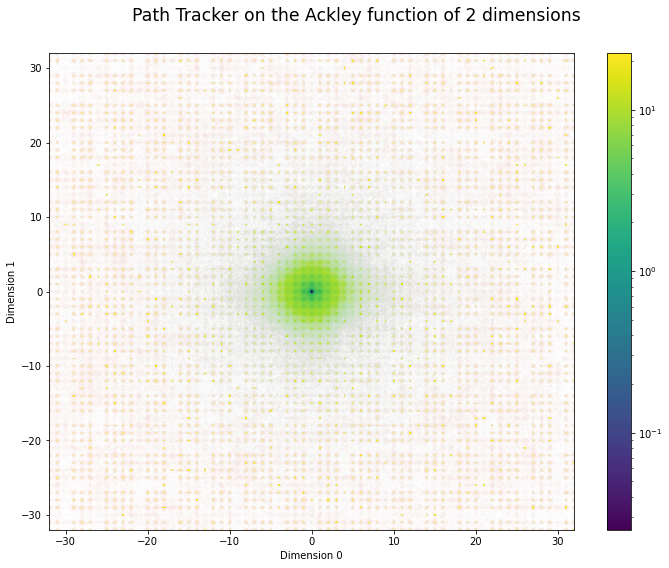

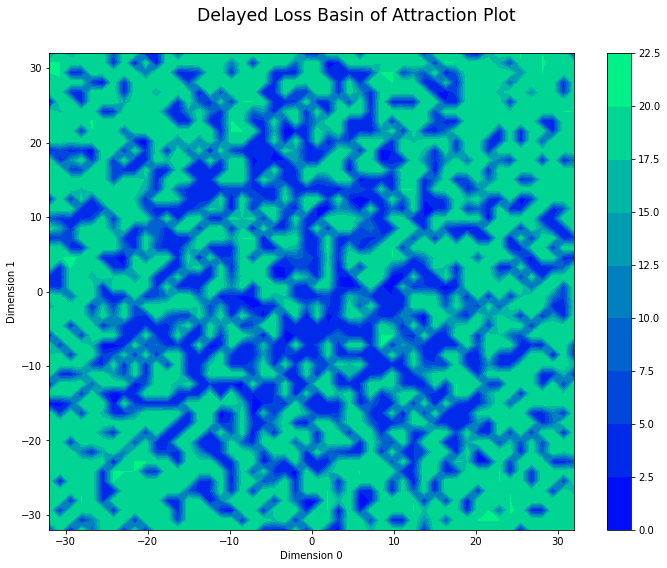

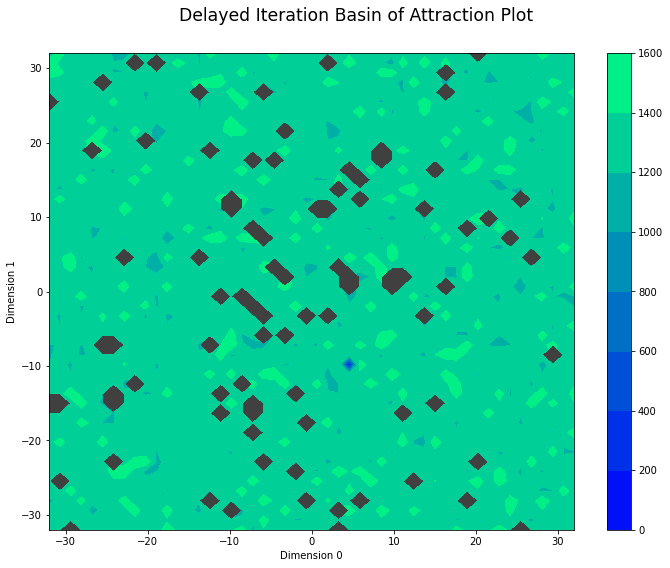

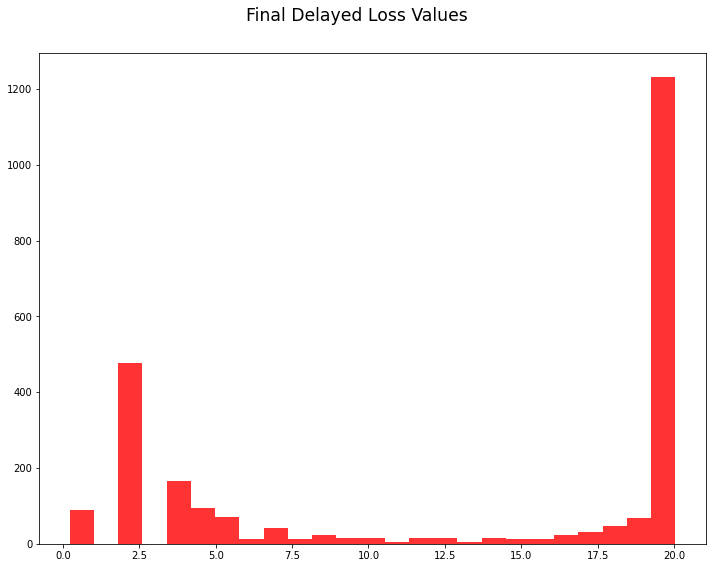

Minimum Delayed Loss: 0.22112351331844637
Mean Delayed Loss: 12.939563634743472
Median Delayed Loss: 19.11182340258039


In [5]:
ackley2d.optimize(50, 'grid', True, random=True, plots=[[True, 'path', 'loss'],[True, 'basin', 'loss'],[True, 'basin', 'iters'],[True, 'finals', 'loss']])

## 2-dimensional 100% Delayed

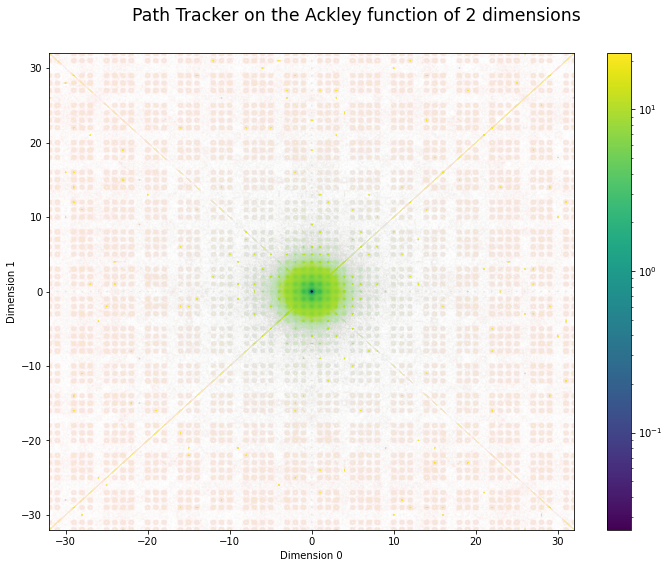

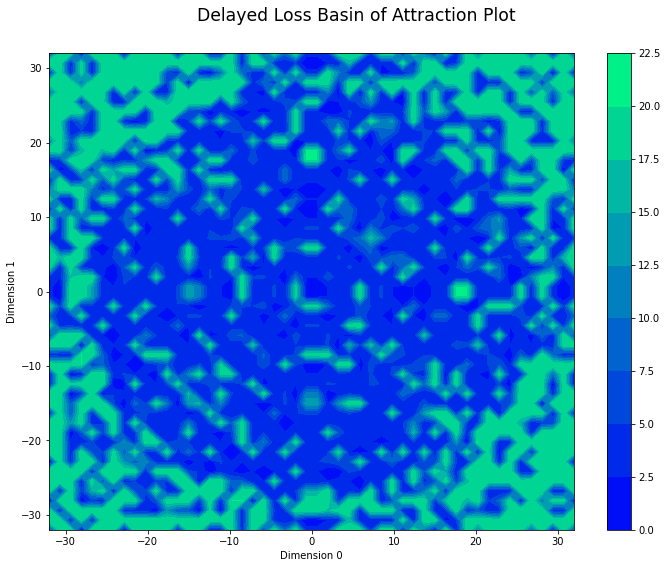

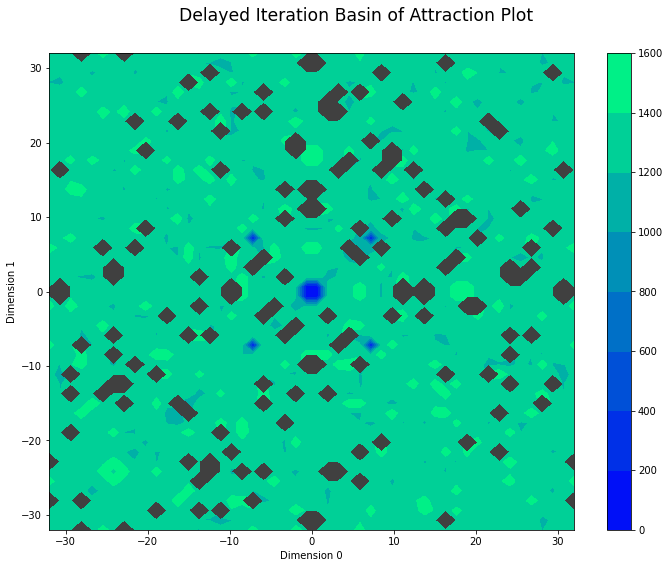

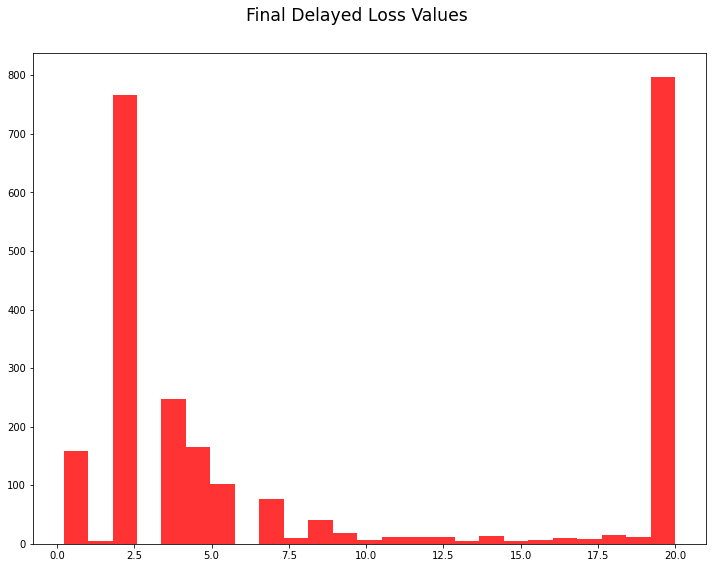

Minimum Delayed Loss: 0.21044190763091608
Mean Delayed Loss: 9.192702451361875
Median Delayed Loss: 4.884065269935281


In [6]:
D = [np.ones(2,dtype=int)]
ackley2d.optimize(50, 'grid', True, random=False, D = D, plots=[[True, 'path', 'loss'],[True, 'basin', 'loss'],[True, 'basin', 'iters'],[True, 'finals', 'loss']])

## 2-dimensional 50% delayed

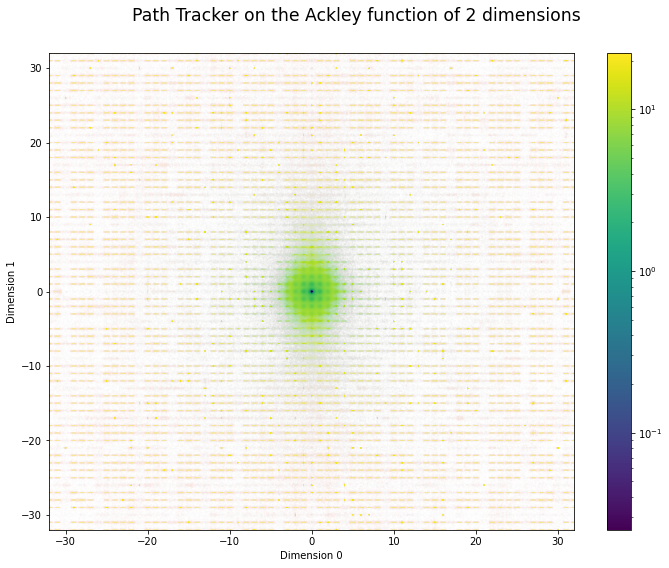

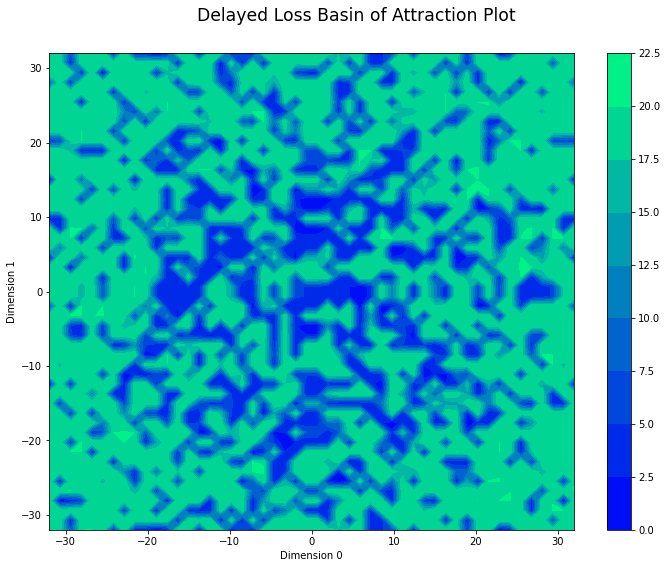

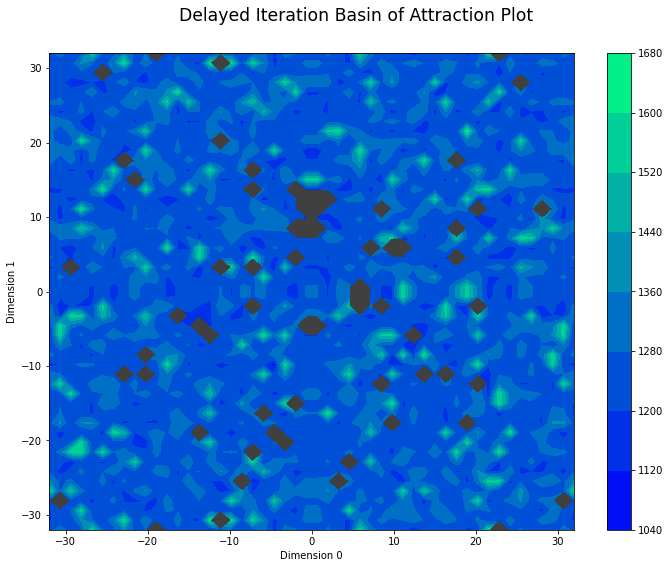

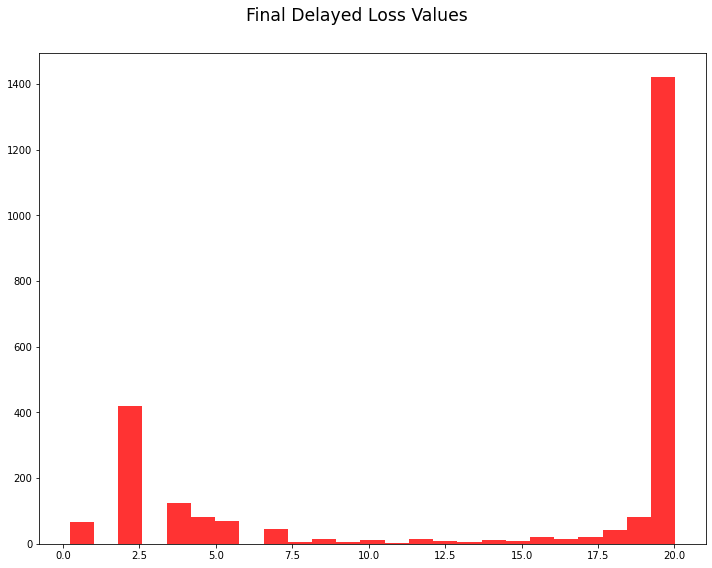

Minimum Delayed Loss: 0.2196898349069767
Mean Delayed Loss: 14.120967959267494
Median Delayed Loss: 19.862785469432065


In [7]:
D = [np.array([1,0],dtype=int)]
ackley2d.optimize(50, 'grid', True, random=False, D = D, plots=[[True, 'path', 'loss'],[True, 'basin', 'loss'],[True, 'basin', 'iters'],[True, 'finals', 'loss']])

## 2-dimensional Undelayed

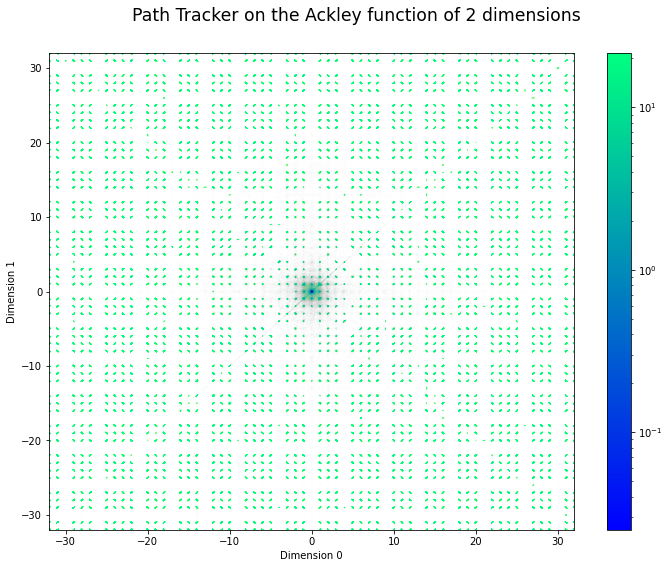

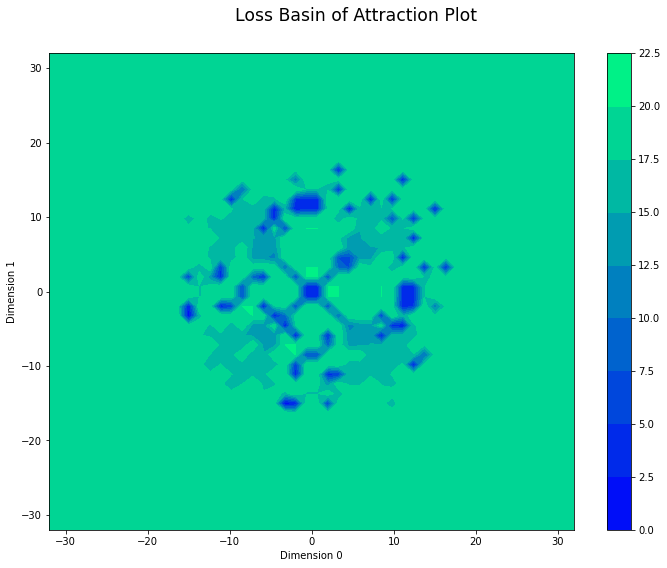

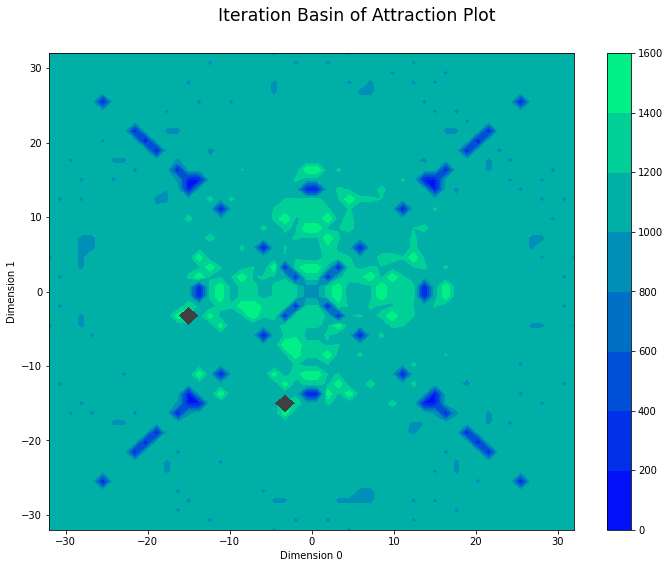

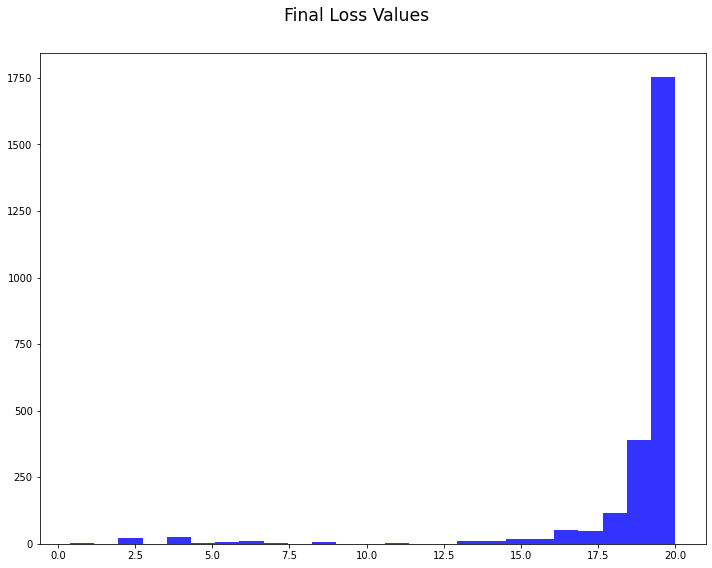

Minimum Loss: 0.3869489076283874
Mean Loss: 18.785564600514988
Median Loss: 19.61959522659073


In [8]:
ackley2d.optimize(50, 'grid', False, plots=[[False, 'path', 'loss'],[False, 'basin', 'loss'],[False, 'basin', 'iters'],[False, 'finals', 'loss']])